# This is the pipeline for shopee matching garantee

In [ ]:
import os

In [ ]:
!nvidia-smi

Fri May  7 14:34:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if (device_name != b'Tesla T4') and (device_name != b'Tesla P4') and (device_name != b'Tesla P100-PCIE-16GB'):
  raise Exception("""
                     Unfortunately this instance does not have a T4, P4 or P100 GPU.\n
                     Please make sure you've configured Colab to request a GPU instance type.\n
                     Sometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100. Resetting the instance.If you get a K80 GPU, try Runtime -> Reset all runtimes...""")
else:
  print('Woo! You got the right kind of GPU!')

Woo! You got the right kind of GPU!


In [ ]:
os.system('pip install pip --upgrade')
os.system('pip install pretrainedmodels')
os.system('pip install -U git+https://github.com/albu/albumentations --no-cache-dir') # data augmentation
os.system('pip install -U git+https://github.com/rwightman/pytorch-image-models.git') # image models 
os.system('pip install pytorch-ignite')
os.system('pip install efficientnet_pytorch') # efficient net torch

0

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

In [ ]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS',cuml.__version__)

RAPIDS 0.19.0


In [ ]:
import numpy as np
import pandas as pd

import albumentations as A
import cv2
import math
import gc
import ast
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pretrainedmodels
import tqdm
import time
import timm
import pickle
import torchvision.models as models
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensor
from albumentations import Rotate 
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from sklearn.metrics import roc_auc_score,accuracy_score,f1_score
from sklearn.model_selection import StratifiedKFold,GroupKFold,RepeatedStratifiedKFold,KFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_random_state
from collections import Counter, defaultdict
from scipy import spatial

from efficientnet_pytorch import EfficientNet
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, VerticalFlip, HorizontalFlip, CenterCrop,
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, SGD
from scipy import spatial

import warnings  
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_rows', 5000)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_PATH = '/content/gdrive/MyDrive/shopee/'

In [ ]:
df = pd.read_csv(DATA_PATH+'train.csv')
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
train = pd.read_csv(DATA_PATH+'siamese_data.csv')
print(train.shape)
train.head()

(55706, 7)


,posting_id_1,posting_id_2,title_1,title_2,image_1,image_2,label
0,train_129225211,train_2278313361,Paper Bag Victoria Secret,PAPER BAG VICTORIA SECRET,0000a68812bc7e98c42888dfb1c07da0.jpg,f83b49a86a0ee8592e3bf0204da3fbdf.jpg,1
1,train_129225211,train_866245802,Paper Bag Victoria Secret,BGSR Jaket Cagoule / Jaket Cagoule Premium / J...,0000a68812bc7e98c42888dfb1c07da0.jpg,5b9a1c01bf01447982a8f0a593909d07.jpg,0
2,train_129225211,train_2591794018,Paper Bag Victoria Secret,Singlet Kazel Circus 1 kotak isi 4pcs singlet...,0000a68812bc7e98c42888dfb1c07da0.jpg,5baebaeb68a13aa2107adebd0dd077f2.jpg,0
3,train_129225211,train_2997658812,Paper Bag Victoria Secret,Hitori Mask - Masker Kain Bahan Scuba Tebal da...,0000a68812bc7e98c42888dfb1c07da0.jpg,5b87d019a03b1c6f04746b743b7fdcd9.jpg,0
4,train_3386243561,train_3423213080,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",Double Tape VHB 3M ORIGINAL 12mm x 4.5mm Busa ...,00039780dfc94d01db8676fe789ecd05.jpg,8cbe4bf9706bc177fd61071ef776be8c.jpg,1


(-0.5, 639.5, 639.5, -0.5)

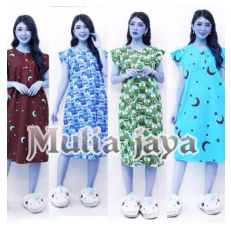

In [ ]:
image = cv2.imread(DATA_PATH+'/train_images/00117e4fc239b1b641ff08340b429633.jpg')
image.shape
plt.imshow(image)
plt.axis('off')

In [ ]:
df['label_group'].nunique()

11014

## Define dataset

In [ ]:
class Config:
    device_type = 'GPU'
    image_size = 512
    batch_size = 32
    n_folds = 5
    n_epochs = 1
    lr = 1e-4
    num_workers = 4
    nprocs = 8  #[1,8]
    eval_freq = 20
    scheduler = 'CosineAnnealingWarmRestarts' #'CosineAnnealingLR'
    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    n_classes = 11014
    debug = False
    T_max=4
    T_0=10
    seed=42

if Config.debug:
    Config.nprocs = 1
if Config.device_type=='GPU':
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)

cuda


In [ ]:
# seed everything
def seed_torch(seed=42):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=Config.seed)

In [ ]:
class ShopeeDataset(Dataset):
    
    def __init__(self,
                 df,
                 path,
                 transform,
                 is_train = True,
                 is_aug = True,
                 
                 ):
        super(ShopeeDataset,self).__init__()
        self.df = df
        self.path = path
        self.transform = transform
        self.is_train = is_train
        self.is_aug = is_aug

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        src = self.path+'/'+self.df.loc[index, 'image']
        image = cv2.imread(src)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.is_aug:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        if self.is_train:
            label = self.df.loc[index,'label_group']
            label = torch.tensor(label).float()
        
        return image, label if self.is_train else image

class ShopeeSiameseDataset(Dataset):
    
    def __init__(self,
                 df,
                 path,
                 transform,
                 is_train = True,
                 is_aug = True,
                 
                 ):
        super(ShopeeSiameseDataset,self).__init__()
        self.df = df
        self.path = path
        self.transform = transform
        self.is_train = is_train
        self.is_aug = is_aug

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        src_1 = self.path+'/'+self.df.loc[index, 'image_1']
        src_2 = self.path+'/'+self.df.loc[index, 'image_2']
        image_1 = cv2.imread(src_1)
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

        image_2 = cv2.imread(src_2)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
        # image = image/255.0
        if self.is_aug:
            augmented_1 = self.transform(image=image_1)
            image_1 = augmented_1['image']
            # image_1 = image_1.transpose(2,0,1)
            # image_1 = image_1/255.0

            augmented_2 = self.transform(image=image_2)
            image_2 = augmented_2['image']
            # image_2 = image_2.transpose(2,0,1)
            # image_2 = image_2/255.0
        
        if self.is_train:
            label = self.df.loc[index,'label']
            label = torch.tensor(label).float()
        
        return image_1, image_2, label if self.is_train else image

In [ ]:
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            Resize(Config.image_size, Config.image_size),
            # RandomResizedCrop(Config.image_size, Config.image_size),
            # # Transpose(p=0.5),
            # HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            # # RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            # # HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            # ShiftScaleRotate(p=0.5),
            # # ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            # CoarseDropout(p=0.2),
            # Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return Compose([
            # RandomResizedCrop(Config.image_size, Config.image_size),
            # CenterCrop(Config.image_size, Config.image_size,p=1.0),
            Resize(Config.image_size, Config.image_size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data=='test':
        return Compose([
                        Resize(Config.image_size,Config.image_size),

                        Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
            ),
                        ToTensorV2(),
        ])

## get pretrained efficientnet models

In [ ]:
#get all saved model names
model_names = glob.glob(DATA_PATH+'*.pth')
model_names

['/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_2_0.19864678126325566.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_3_0.18886887905865352.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_4_0.19710620647427257.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_0_0.19649354238704467.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_1_0.17506829626027126.pth']

In [ ]:
class ShoppeeSiameseModel(nn.Module):

    def __init__(self,base_name,out_features):
        super(ShoppeeSiameseModel,self).__init__()
        self.base_name = base_name
        self.base = timm.create_model(model_name=self.base_name, pretrained=True)
        in_features = self.base.classifier.in_features
        # in_features = self.base.fc.in_features
        self.base.classifier = nn.Identity()
        self.base.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)

        # self.dropout = nn.Dropout(p=0.1)
        # self.classifier = nn.Sequential(
        #                                 nn.Linear(in_features, in_features),
        #                                 nn.ReLU(),
        #                                 # nn.Linear(in_features//2,out_features)
        #                                 )
        
        # self.final = nn.Linear(in_features,1)
        self.final = nn.Sequential(
                                    nn.Dropout(0.1),
                                    nn.Linear(in_features,1)
                                    )

    
    def forward_once(self,x):
        bs = x.size(0)
        x = self.base(x)
        x = self.pooling(x).view(bs,-1)
        # x = self.classifier(x)
        return x
    
    def forward(self,image_1,image_2):
        bs = image_1.size(0)
        feature_1 = self.forward_once(image_1)
        feature_2 = self.forward_once(image_2)

        # feature = torch.abs(feature_1 - feature_2)
        feature = torch.mul(feature_1,feature_2)
        feature = F.normalize(feature)
        # feature = nn.Dropout(p=0.2)(feature)
        # feature = nn.ReLU()(feature)
        # feature = nn.Sigmoid()(feature)
        # feature = feature.view(bs,-1)
        output = self.final(feature)

        return output

In [ ]:
def get_feature_extractor(device,base_name,model_path):
    model = ShoppeeSiameseModel(base_name=base_name,out_features=128)
    model.to(device)
    model.load_state_dict(torch.load(model_path))
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.to(device)
    return feature_extractor

In [ ]:
device = torch.device('cuda')
feature_extractor = get_feature_extractor(device,base_name='efficientnet_b3',model_path=model_names[11])
feature_extractor.to(device)

In [ ]:
timm.list_models()

In [ ]:
# #load the pretrained pytorch models
base_name = 'resnet200d'
model = ShoppeeSiameseModel(base_name=base_name,out_features=128)
model.to(device)


In [ ]:
# feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
# feature_extractor.to(device)

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

train_inds = []
valid_inds = []
for train_idx, valid_idx in kf.split(train,train['label']):
    print(len(train_idx)/len(valid_idx))
    train_inds.append(train_idx)
    valid_inds.append(valid_idx)

In [ ]:
train_df = train.loc[train_inds[2]].reset_index(drop=True)
valid_df = train.loc[valid_inds[2]].reset_index(drop=True)
train_df.shape,valid_df.shape

((44565, 7), (11141, 7))

In [ ]:
valid_dataset = ShopeeSiameseDataset(df=valid_df,path=DATA_PATH+'train_images/',transform=get_transforms(data='valid'),is_train=True,is_aug=True)

In [ ]:
valid_dataloader = torch.utils.data.DataLoader(
                                               valid_dataset,
                                               batch_size = 64,
                                               drop_last=False,
                                               num_workers = 8,
                                               shuffle=False
                                               
                                               )

In [ ]:
%%time
with torch.no_grad():
    preds = []
    trues = []

    for step, (images_1,images_2,labels) in enumerate(valid_dataloader):
        if step>=5:break
        images_1 = images_1.to(device)
        images_2 = images_2.to(device)

        v1 = feature_extractor(images_1)
        v2 = feature_extractor(images_2)

        v1 = v1.to('cpu').numpy().squeeze()
        v2 = v2.to('cpu').numpy().squeeze()
        scores = [1 - np.clip(spatial.distance.cosine(x, y),0,1) for (x,y) in zip(v1,v2)]

        preds.extend(scores)
        trues.extend(labels.to('cpu').numpy().squeeze())

CPU times: user 2.55 s, sys: 2.26 s, total: 4.81 s
Wall time: 47.3 s


In [ ]:
pred_labels = (np.array(preds)>0.5).astype(int)
print((pred_labels==trues).mean())
result = pd.DataFrame(columns=['prob','pred_label','trues'])
result['prob'] = preds
result['pred_label'] = pred_labels
result['trues'] = trues

0.8625796607126829


In [ ]:
same_labels = valid_df.loc[valid_df.label==1].index.values
diff_labels = valid_df.loc[~valid_df.index.isin(same_labels)].index.values

In [ ]:
ind = same_labels[567]
images_1, images_2,label = valid_dataset.__getitem__(ind)
plt.subplot(1,2,1)
plt.imshow(images_1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(images_2.permute(1,2,0))
print(preds[ind],label,ind)
        

# collect all similar items

In [ ]:
dataset = ShopeeDataset(df=df,path=DATA_PATH+'train_images/',transform=get_transforms(data='valid'),is_train=True,is_aug=True)
dataloader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size = 32,
    drop_last = False,
    num_workers = Config.num_workers,
    shuffle=False,
)

In [ ]:
emb_dim = 1536
embeddings = []

In [ ]:
%%time
tbar = tqdm(dataloader, desc='Calculating embedding')
with torch.no_grad(): # this is important
    for step, (images,labels) in enumerate(tbar):
        # if step>5:break
        images = images.to(device)
        labels = labels.to(device)

        v = feature_extractor(images)
        v = v.to('cpu').numpy().squeeze()
        embeddings.extend(v)


CPU times: user 1min 54s, sys: 1min 16s, total: 3min 11s
Wall time: 41min 17s


In [ ]:
embeddings = np.squeeze(embeddings)
embeddings.shape

(34250, 1536)

In [ ]:
with open(DATA_PATH+'efficientnet_b4_size_512_fold_3.pkl','wb') as handle:
    pickle.dump(embeddings,handle)
handle.close()

In [ ]:
embeddings.shape

(34250, 1536)

In [ ]:
dist = np.clip(spatial.distance.cdist([embeddings[15459]],embeddings,'cosine'),0,1)[0]
dist

array([0.84581011, 0.77036446, 0.79151774, ..., 0.97904526, 0.80370894,
       0.91452787])

In [ ]:
np.argsort(dist)[:10],dist[15459]

(array([15459, 20841, 23261, 20283, 27086, 28084, 22785, 25806,  6295,
        13863]), 0.0)

Text(0.5, 1.0, '98002181')

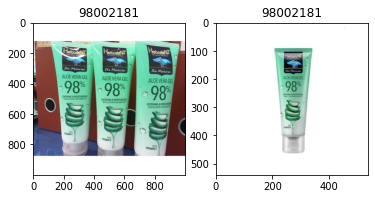

In [ ]:
i,j = 15459,20283
image_1 = cv2.imread(DATA_PATH+'train_images/'+df.iloc[i]['image'])
image_2 = cv2.imread(DATA_PATH+'train_images/'+df.iloc[j]['image'])

plt.subplot(1,2,1)
plt.imshow(image_1)
plt.title(df.iloc[i]['label_group'])
plt.subplot(1,2,2)
plt.imshow(image_2)
plt.title(df.iloc[j]['label_group'])

# use cuML KNN for classify embeddings

# use cuML from rapids for tfidf vectorizer

In [ ]:
test = pd.read_csv(DATA_PATH+'train.csv')
test_gf = cudf.DataFrame(test)
test_gf.shape

(34250, 5)

In [ ]:
test_gf.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
print('Computing text embeddings...')
model = TfidfVectorizer(stop_words='english', binary=True, max_features=25_000)
text_embeddings = model.fit_transform(test_gf.title).toarray()
print('text embeddings shape',text_embeddings.shape)

Computing text embeddings...
text embeddings shape (34250, 24939)


In [ ]:
preds = []
CHUNK = 1024*4

print('Finding similar titles...')
CTS = len(test)//CHUNK
if len(test)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test))
    print('chunk',a,'to',b)
    
    # COSINE SIMILARITY DISTANCE
    cts = cupy.matmul( text_embeddings, text_embeddings[a:b].T).T
    
    for k in range(b-a):
        IDX = cupy.where(cts[k,]>0.7)[0]
        o = test.iloc[cupy.asnumpy(IDX)].posting_id.values
        preds.append(o)
        
del model, text_embeddings
_ = gc.collect()

Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [ ]:
test['preds'] = preds
test.head()

,posting_id,image,image_phash,title,label_group,preds
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3576714541, train_150..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,[train_3369186413]


# Final submission pipeline for kaggle submission

In [ ]:
# helper functions
class ShoppeeSiameseModel(nn.Module):

    def __init__(self,base_name,out_features):
        super(ShoppeeSiameseModel,self).__init__()
        self.base_name = base_name
        self.base = timm.create_model(model_name=self.base_name, pretrained=True)
        in_features = self.base.classifier.in_features
        # in_features = self.base.fc.in_features
        self.base.classifier = nn.Identity()
        self.base.global_pool = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.final = nn.Sequential(
                                    nn.Dropout(0.1),
                                    nn.Linear(in_features,1)
                                    )

    
    def forward_once(self,x):
        bs = x.size(0)
        x = self.base(x)
        x = self.pooling(x).view(bs,-1)
        return x
    
    def forward(self,image_1,image_2):
        bs = image_1.size(0)
        feature_1 = self.forward_once(image_1)
        feature_2 = self.forward_once(image_2)
        feature = torch.mul(feature_1,feature_2)
        feature = F.normalize(feature)
        output = self.final(feature)

        return output


# extract embedding vector
def get_feature_extractor(device,base_name,model_path):
    model = ShoppeeSiameseModel(base_name=base_name,out_features=128)
    model.to(device)
    model.load_state_dict(torch.load(model_path))
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    feature_extractor.to(device)
    return feature_extractor

In [ ]:
# image embedding creation

def image_embeddings(feature_extractor,df,emb_dim):
    """
    model: pretrained model
    df: which df is used to calculate emb vec
    emb_dim: the length og emb vec
    """

    embeddings = []
    chunck_size = 1024*4

    n_chunk = len(df)//chunck_size

    for i in range(n_chunk):
        a,b = i*chunk_size, (i+1)*chunk_size
        if b>len(df):
            b = len(df)

        dataset = ShopeeDataset(df=df[a:b],path=DATA_PATH+'train_images/',transform=get_transforms(data='valid'),is_train=True,is_aug=True)
        dataloader = torch.utils.data.DataLoader(
            dataset = dataset,
            batch_size = 32,
            drop_last = False,
            num_workers = Config.num_workers,
            shuffle=False,
        )

        for step,(images,labels) in enumerate(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                v = feature_extractor(images)
                v = v.to('cpu').numpy().squeeze()
                embeddings.extend(v)
    
    return embeddings

    

In [ ]:
#use RAPIDS KNN models for finding nearest items

def knn_images(image_embeddings,test):
    KNN = 50
    if len(test)<=3: KNN=2

    model = NearestNeighbors(n_neighbors=KNN)
    model.fit(image_embeddings)

    preds = []
    CHUNK = 1024*4

    print('..... finding similar images')
    n_chunks = len(image_embeddings)//CHUNK

    if len(image_embeddings)%CHUNK!=0: n_chunks+=1

    for j in range(n_chunks):

        if j>5:break
        a,b = j*CHUNK, (j+1)*CHUNK
        b = min(b,len(image_embeddings))

        distance, indices = model.kneighbors(image_embeddings[a:b,])
        # print(distance)


        for k in range(b-a):
            IDX = np.where(distance[k,]<4.5)[0]
            IDS = indices[k,IDX]
            o = test.iloc[IDS].posting_id.values
            preds.append(o)

    del model, image_embeddings
    gc.collect()

    return preds

In [ ]:
# get neighbors using threshold searching

def search_threshold(df,embeddings,KNN=50,image=True):

    model = NearestNeighbors(n_neighbors=KNN)
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)

    if image:
        thresholds = list(np.arange(1.5, 6.0, 0.1))
        scores = []
        for threshold in thresholds:
            predictions = []
            for k in range(embeddings.shape[0]):
                idx = np.where(distances[k,] < threshold)[0]
                ids = indices[k,idx]
                # print('anna',df['posting_id'].iloc[ids].values)
                posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
                predictions.append(posting_ids)
            df['pred_matches'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches'])
            score = df['f1'].mean()
            print(f'Our f1 score for threshold {threshold} is {score}')
            scores.append(score)

        thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
        max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
        best_threshold = max_score['thresholds'].values[0]
        best_score = max_score['scores'].values[0]
        print(f'Our best score is {best_score} and has a threshold {best_threshold}')

    else:
        thresholds = list(np.arange(1, 35, 1))
        scores = []
        for threshold in thresholds:
            
            # model = TfidfVectorizer(stop_words='english', binary=True)
            # text_embeddings = model.fit_transform(test.title).toarray()
            predictions = []
            CHUNK = 1024*4

            print('Finding similar titles...')
            CTS = len(test)//CHUNK
            if len(test)%CHUNK!=0: CTS += 1
            for j in range( CTS ):
                
                a = j*CHUNK
                b = (j+1)*CHUNK
                b = min(b,len(test))
                print('chunk',a,'to',b)
                
                # COSINE SIMILARITY DISTANCE
                cts = cupy.matmul( embeddings, embeddings[a:b].T).T
                
                for k in range(b-a):
                    IDX = cupy.where(cts[k,]<threshold)[0]
                    o = test.iloc[cupy.asnumpy(IDX)].posting_id.values
                    predictions.append(o)
            
            # del model, text_embeddings
            # _ = gc.collect()

            df['pred_matches_test'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches_test'])
            score = df['f1'].mean()
            print(f'Our f1 score for threshold {threshold} is {score}')
            scores.append(score)
            
        thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
        max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
        best_threshold = max_score['thresholds'].values[0]
        best_score = max_score['scores'].values[0]
        print(f'Our best score is {best_score} and has a threshold {best_threshold}')

    return best_threshold,distances,indices,model

    
def get_neighbors(df,embeddings,KNN=50, image=True):
    model = NearestNeighbors(n_neighbors=KNN)
    model.fit(embeddings)
    distances, indices = model.kneighbors(embeddings)

    if GET_CV:
        if image:
            thresholds = list(np.arange(0.2, 6.0, 0.1))
        else:
            thresholds = list(np.arange(31, 35, 1))
        scores = []
        for threshold in thresholds:
            predictions = []
            for k in range(embeddings.shape[0]):
                idx = np.where(distances[k,] < threshold)[0]
                ids = indices[k,idx]
                posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
                predictions.append(posting_ids)
            df['pred_matches'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches'])
            score = df['f1'].mean()
            print(f'Our f1 score for threshold {threshold} is {score}')
            scores.append(score)
        thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
        max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
        best_threshold = max_score['thresholds'].values[0]
        best_score = max_score['scores'].values[0]
        print(f'Our best score is {best_score} and has a threshold {best_threshold}')
        
        # Use threshold
        predictions = []
        for k in range(embeddings.shape[0]):
            ids = np.array([])
            # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
            if image:
                idx = np.where(distances[k,] < best_threshold)[0]
                ids = indices[k,idx]
            else:
                idx = np.where(distances[k,] < 20.0)[0]
                ids = indices[k,idx]
                if (len(idx)>1):
                    arr = distances[k,np.where(distances[k,]<20)[0]][1:]
                    mean = np.mean(arr)
                    standard_deviation = np.std(arr)
                    if(standard_deviation>0):
                        distance_from_mean = abs(arr - mean)
                        max_deviations = 2
                        not_outlier = distance_from_mean < max_deviations * standard_deviation
                        max_dist = arr[not_outlier][-1]
                        idx = np.where(distances[k,] <= max_dist)[0]
                        ids = indices[k,idx]
            posting_ids = df['posting_id'].iloc[ids].values
            predictions.append(posting_ids)
    
    # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
    else:
        predictions = []
        for k in tqdm(range(embeddings.shape[0])):
            ids = np.array([])
            if image:
                idx = np.where(distances[k,] < best_threshold)[0]
                ids = indices[k,idx]
            else:
                idx = np.where(distances[k,] < 16.0)[0]
                ids = indices[k,idx]
                if (len(idx)>1):
                    arr = distances[k,np.where(distances[k,]<16.0)[0]][1:]
                    mean = np.mean(arr)
                    standard_deviation = np.std(arr)
                    if(standard_deviation>0):
                        distance_from_mean = abs(arr - mean)
                        max_deviations = 2
                        not_outlier = distance_from_mean < max_deviations * standard_deviation
                        max_dist = arr[not_outlier][-1]
                        idx = np.where(distances[k,] <= max_dist)[0]
                        ids = indices[k,idx]
            
            posting_ids = df['posting_id'].iloc[ids].values
            predictions.append(posting_ids)
        
    del model, distances, indices
    gc.collect()
    return df, predictions

def get_neighbor_2(df,embeddings,image=True):
    if GET_CV:
        if image:
            thresholds = list(np.arange(0.01, 1.0, 0.01))
        else:
            thresholds = list(np.arange(31, 35, 1))
        scores = []
        indices = np.array(df.index.values)
        # distances = np.clip(spatial.distance.cdist(embeddings,embeddings,'cosine'),0,1)
        CHUNK = 256
        CTS = len(df)//CHUNK
        if len(df)%CHUNK!=0:
            CTS+=1

        x = cupy.array(embeddings)

        for threshold in thresholds:
            predictions = []
            
            for j in range( CTS ):
                # if k>=5:break
                # if k%500==0:print(k,end=' ')
                a, b = j*CHUNK, (j+1)*CHUNK
                b = min(b,len(df))
                print('chunk:{} to {}'.format(a,b))
                # distance = np.clip(spatial.distance.cdist([embeddings[k]],embeddings,'cosine'),0,1)[0]
                
                y = cupy.array(embeddings[a:b]).T
                distance = cupy.matmul(x,y).T
                # print(distance)
                idx = cupy.where(distance >0.75)[0]

                for k in range(b-a):
                    IDX = cupy.where(distance[k,]>0.75)[0]
                    o = df.iloc[cupy.asnumpy(IDX)].posting_id.values
                    predictions.append(o)
                    # del IDX
                    cupy._default_memory_pool.free_all_blocks()
                    # gc.collect()
                del y,distance
                gc.collect()
                # print(idx)

                # ids = indices[idx]
                # posting_ids=  df.iloc[cupy.asnumpy(idx)].posting_id.values
                # # print(ids)
                # if len([ids])==1:
                #     posting_ids = df['posting_id'].iloc[ids]
                # else:
                #     posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
                # predictions.append(posting_ids)
            df['pred_matches'] = predictions
            df['f1'] = f1_score(df['matches'], df['pred_matches'])
            score = df['f1'].mean()
            print(f'Our f1 score for threshold {threshold} is {score}')
            scores.append(score)
        thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
        max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
        best_threshold = max_score['thresholds'].values[0]
        best_score = max_score['scores'].values[0]
        print(f'Our best score is {best_score} and has a threshold {best_threshold}')
    

# for f1
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [ ]:
test = df
test.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
tmp = test.groupby(['label_group'])['posting_id'].unique().to_dict()
test['matches'] = test['label_group'].map(tmp)
test['matches'] = test['matches'].apply(lambda x: ' '.join(x))

In [ ]:
dataset = ShopeeDataset(df=df,path=DATA_PATH+'train_images/',transform=get_transforms(data='valid'),is_train=True,is_aug=True)
dataloader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size = 32,
    drop_last = False,
    num_workers = Config.num_workers,
    shuffle=False,
)

In [ ]:
model_names = glob.glob(DATA_PATH+'*.pth')
model_names

['/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_2_0.19864678126325566.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_3_0.18886887905865352.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_4_0.19710620647427257.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_0_0.19649354238704467.pth',
 '/content/gdrive/MyDrive/shopee/efficientnet_b3_size_512_fold_1_0.17506829626027126.pth']

In [ ]:
device = torch.device('cuda')
feature_extractor = get_feature_extractor(device,base_name='efficientnet_b3',model_path=model_names[4])
feature_extractor.to(device)

In [ ]:
%%time
emb_dim = 1536
embeddings = []
tbar = tqdm(dataloader, desc='Calculating embedding')
with torch.no_grad(): # this is important
    for step, (images,labels) in enumerate(tbar):
        # if step>5:break
        images = images.to(device)
        labels = labels.to(device)

        v = feature_extractor(images)
        v = v.to('cpu').numpy().squeeze()
        embeddings.extend(v)
embeddings = np.squeeze(embeddings)
# with open(DATA_PATH+'efficientnet_b4_size_512_fold_1.pkl','wb') as handle:
#     pickle.dump(embeddings,handle)
# handle.close()


CPU times: user 3min 6s, sys: 2min 20s, total: 5min 27s
Wall time: 45min 57s


In [ ]:
with open(DATA_PATH+'efficientnet_b4_size_512_fold_0.pkl','rb') as handle:
    embeddings_0 = pickle.load(handle)
handle.close()

with open(DATA_PATH+'efficientnet_b4_size_512_fold_1.pkl','rb') as handle:
    embeddings_1 = pickle.load(handle)
handle.close()

with open(DATA_PATH+'efficientnet_b4_size_512_fold_2.pkl','rb') as handle:
    embeddings_2 = pickle.load(handle)
handle.close()

with open(DATA_PATH+'efficientnet_b4_size_512_fold_3.pkl','rb') as handle:
    embeddings_3 = pickle.load(handle)
handle.close()

with open(DATA_PATH+'efficientnet_b4_size_512_fold_4.pkl','rb') as handle:
    embeddings_4 = pickle.load(handle)
handle.close()

In [ ]:
embeddings_image = embeddings_0*0.2+embeddings_1*0.2+embeddings_2*0.2+embeddings_3*0.2+embeddings_4*0.2

In [ ]:
embeddings_image.shape

(34250, 1536)

In [ ]:
# GET_CV=True
# test, image_predictions = get_neighbors(test, embeddings,KNN=25, image = True)

In [ ]:
best_thred_image,distances,indices,model_image_emb = search_threshold(test, embeddings_image,KNN=25,image=True)
print('the best thred for image prediction is:{}'.format(best_thred_image))

In [ ]:
# Use threshold
predictions = []
image=True
for k in range(embeddings_image.shape[0]):
    ids = np.array([])
    # Because we are predicting the test set that have 70K images and different label groups, confidence should be smaller
    if image:
        idx = np.where(distances[k,] < best_thred_image)[0]
        ids = indices[k,idx]
    else:
        idx = np.where(distances[k,] < 20.0)[0]
        ids = indices[k,idx]
        if (len(idx)>1):
            arr = distances[k,np.where(distances[k,]<20)[0]][1:]
            mean = np.mean(arr)
            standard_deviation = np.std(arr)
            if(standard_deviation>0):
                distance_from_mean = abs(arr - mean)
                max_deviations = 2
                not_outlier = distance_from_mean < max_deviations * standard_deviation
                max_dist = arr[not_outlier][-1]
                idx = np.where(distances[k,] <= max_dist)[0]
                ids = indices[k,idx]
    posting_ids = df['posting_id'].iloc[ids].values
    predictions.append(posting_ids)

test['pred2'] = predictions

In [ ]:
distances, indices = model_image_emb.kneighbors(embeddings_image[1:5,])

In [ ]:
test_df = pd.read_csv(DATA_PATH+'test.csv')
test_df

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


### use text embedding

In [ ]:
train_gf = cudf.read_csv(DATA_PATH+'train.csv')
print('train shape is', train_gf.shape )
train_gf.head()

train shape is (34250, 5)


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
model_text = TfidfVectorizer(stop_words='english', binary=True,max_features=25_000)
text_embeddings = model_text.fit_transform(train_gf.title).toarray()
print('text embeddings shape is',text_embeddings.shape)

text embeddings shape is (34250, 24939)


In [ ]:
# best_thred_test = search_threshold(train_gf, text_embeddings,KNN=25,image=False)
# print('the best thred for image prediction is:{}'.format(best_thred_test))

In [ ]:
preds = []
CHUNK = 1024*4

print('Finding similar titles...')
CTS = len(test)//CHUNK
if len(test)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test))
    print('chunk',a,'to',b)
    
    # COSINE SIMILARITY DISTANCE
    cts = cupy.matmul( text_embeddings, text_embeddings[a:b].T).T
    
    for k in range(b-a):
        IDX = cupy.where(cts[k,]>0.7)[0]
        o = test.iloc[cupy.asnumpy(IDX)].posting_id.values
        preds.append(o)
        
del model_text, text_embeddings
_ = gc.collect()
test['pred3'] = preds

Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


In [ ]:
tmp = test.groupby('image_phash').posting_id.agg('unique').to_dict()
test['pred4'] = test.image_phash.map(tmp)
test.head()

,posting_id,image,image_phash,title,label_group,matches,pred_matches,f1,pred2,pred3,pred4
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,train_129225211 train_2278313361,train_129225211 train_523363809 train_29257018...,0.148148,[train_129225211],"[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,train_3386243561 train_3423213080,train_3386243561 train_3423213080 train_212059...,0.148148,"[train_3386243561, train_3423213080]",[train_3386243561],[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,train_2288590299 train_3803689425,train_2288590299 train_1557977654 train_409800...,0.074074,[train_2288590299],[train_2288590299],[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,train_2406599165 train_3342059966,train_2406599165 train_3230106292 train_224249...,0.074074,[train_2406599165],"[train_2406599165, train_3576714541, train_150...",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,train_3369186413 train_921438619,train_3369186413 train_921438619 train_1440816...,0.148148,"[train_3369186413, train_921438619]",[train_3369186413],[train_3369186413]


In [ ]:
def combine_for_sub(row):
    x = np.concatenate([row.pred2,row.pred3, row.pred4])
    return ' '.join( np.unique(x) )

def combine_for_cv(row):
    x = np.concatenate([row.pred2,row.pred3, row.pred4])
    return np.unique(x)

def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

In [ ]:

tmp = test.groupby('label_group').posting_id.agg('unique').to_dict()
test['target'] = test.label_group.map(tmp)
test['oof'] = test.apply(combine_for_cv,axis=1)
test['f1'] = test.apply(getMetric('oof'),axis=1)
print('CV Score =', test.f1.mean() )

test['matches'] = test.apply(combine_for_sub,axis=1)

CV Score = 0.73841337669991


In [ ]:
test[['posting_id','matches']].to_csv('submission.csv',index=False)
sub = pd.read_csv('submission.csv')
sub.head()

,posting_id,matches
0,train_129225211,train_129225211 train_2278313361
1,train_3386243561,train_3386243561 train_3423213080
2,train_2288590299,train_2288590299
3,train_2406599165,train_1508100548 train_1744956981 train_240659...
4,train_3369186413,train_3369186413 train_921438619
